[View in Colaboratory](https://colab.research.google.com/github/andreinechaev/Dermotology_CNN/blob/master/SkinScanner.ipynb)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

%matplotlib inline

Using TensorFlow backend.


In [0]:
### Helper functions

def normalize(img, beta=255):
  cv2.normalize(img, img, alpha=0, beta=beta, norm_type=cv2.NORM_MINMAX)

def to_grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def resize(img, size=(224, 224)):
  height, width = img.shape[:2]

  if height > width:
      diff = height - width
      pad = int(diff / 2)
      res = img[pad:height - pad, :]
  elif width > height:
      diff = width - height
      pad = int(diff / 2)
      res = img[:, pad:width - pad]
  else:
      res = img

  return cv2.resize(res, size)
  
def reshape(img):
  height, width = img.shape[:2]
  tmp = img_to_array(img)  # this is a Numpy array with shape (3, 224, 224)
  return tmp.reshape((3, height, width))

In [14]:
!pip install lxml

In [0]:
!mkdir data

In [17]:
import requests
from lxml import html
import os
import cv2
import numpy as np
import csv


if __name__ == '__main__':
    resp = requests.get('https://medicine.uiowa.edu/dermatology/education/clinical-skin-disease-images')

    if resp.status_code != 200:
        exit(1)

    tree = html.fromstring(resp.content)
    elements = tree.xpath('//*[@id="content"]/div/div[1]/div/article/div/div/div/div/ul')

    disease_map = {}

    for elem in elements:
        link_elements = elem.xpath('li/a')
        for le in link_elements:
            link = le.attrib['href']
            index = link.rindex('/')
            name = link[index + 1:]
            disease_map[name] = link

    dis_images = []
    for k, v in disease_map.items():
        r = requests.get('https:' + v)
        t = html.fromstring(r.content)
        p_elems = t.xpath('//*[@id="content"]/div/div[1]/div/article/div/div/div/div/p')

        images = []
        for e in p_elems:
            img = e.xpath('img')
            for i in e:
                link = i.attrib['src']
                images.append('https:' + link)

        dis_images.append((k, images))

    length = 0
    for dis in dis_images:
        length += len(dis[1])

    print(f"Got {length} links")

    with open('data/meta.csv', 'w+') as csv_file:
        writer = csv.writer(csv_file, quoting=csv.QUOTE_ALL, escapechar='\\', quotechar='"')
        t = 0
        for dis in dis_images:
            path = 'data/' + dis[0]
            os.mkdir('data/' + dis[0])
            for l in dis[1]:
                index = l.rindex('/')
                file = path + '/' + l[index + 1:]
                resp = requests.get(l)
                arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
                img = cv2.imdecode(arr, -1)
                img = resize(img)
                cv2.imwrite(file, img)
                fields = [t, dis[0], file]
                writer.writerow(fields)
            t += 1

    print('Done')

Got 374 links
Done


In [0]:
names = []
labels = []
images = []
with open('data/meta.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        labels.append(row[0])
        names.append(row[1])
        img = cv2.imread(row[2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        normalize(img)
        images.append(img)

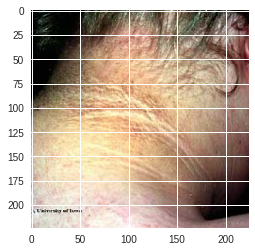

In [87]:
plt.imshow(images[0])

In [88]:
from sklearn.model_selection import train_test_split

sorted_classes, class_indices, class_counts = np.unique(labels, return_index=True, return_counts=True)
n_classes = len(sorted_classes)

# images = [np.reshape(i, (3, 224, 224)) for i in images]
images, test_images, labels, test_labels = train_test_split(images, labels, test_size=0.12, random_state=0)

n_train = len(images)

n_test = len(test_images)

image_shape = images[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 329
Number of testing examples = 45
Image data shape = (224, 224, 3)
Number of classes = 167


In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 224, 224)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

model.add(Conv2D(32, (3, 3), data_format="channels_first"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(167))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

images = [reshape(i) for i in images]
test_images = [reshape(i) for i in test_images]

print(f"Reshaped image: {images[0].shape}")

Reshaped image: (3, 224, 224)


In [90]:
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from time import time

batch_size = 128
epochs = 50



# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True)

x_train = np.array(images)
y_train = np_utils.to_categorical(labels, n_classes)

print(f"x_train shape: {x_train.shape}")

x_test = np.array(test_images)
y_test = np_utils.to_categorical(test_labels, n_classes)

train_datagen.fit(images)

model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(images)/batch_size, epochs=epochs,
                    validation_data=test_datagen.flow(x_test, y_test, batch_size=batch_size),
                    validation_steps=len(images)/batch_size)

model.save_weights('first_try.h5')

x_train shape: (329, 3, 224, 224)


/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:957: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (329, 3, 224, 224) (224 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (329, 3, 224, 224) (224 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3

Epoch 1/50
3/2 [===================================] - 11s 4s/step - loss: 0.7608 - acc: 0.5617 - val_loss: 0.5778 - val_acc: 0.6915
Epoch 2/50
3/2 [===================================] - 8s 3s/step - loss: 0.6422 - acc: 0.6558 - val_loss: 0.5509 - val_acc: 0.7531
Epoch 3/50
3/2 [===================================] - 8s 3s/step - loss: 0.5805 - acc: 0.6966 - val_loss: 0.4151 - val_acc: 0.8232
Epoch 4/50
3/2 [===================================] - 8s 3s/step - loss: 0.5420 - acc: 0.7435 - val_loss: 0.4034 - val_acc: 0.8873
Epoch 5/50
3/2 [===================================] - 8s 3s/step - loss: 0.4836 - acc: 0.7772 - val_loss: 0.2843 - val_acc: 0.9092
Epoch 6/50
3/2 [===================================] - 8s 3s/step - loss: 0.4270 - acc: 0.8085 - val_loss: 0.2632 - val_acc: 0.9391
Epoch 7/50
3/2 [===================================] - 8s 3s/step - loss: 0.3723 - acc: 0.8378 - val_loss: 0.2018 - val_acc: 0.9554
Epoch 8/50
3/2 [===================================] - 8s 3s/step - loss: 0

Epoch 23/50
3/2 [===================================] - 8s 3s/step - loss: 0.0835 - acc: 0.9816 - val_loss: 0.0413 - val_acc: 0.9940
Epoch 24/50
3/2 [===================================] - 8s 3s/step - loss: 0.0799 - acc: 0.9837 - val_loss: 0.0448 - val_acc: 0.9940
Epoch 25/50
3/2 [===================================] - 8s 3s/step - loss: 0.0768 - acc: 0.9841 - val_loss: 0.0394 - val_acc: 0.9940
Epoch 26/50
3/2 [===================================] - 8s 3s/step - loss: 0.0728 - acc: 0.9860 - val_loss: 0.0411 - val_acc: 0.9940
Epoch 27/50
3/2 [===================================] - 8s 3s/step - loss: 0.0698 - acc: 0.9863 - val_loss: 0.0493 - val_acc: 0.9940
Epoch 28/50
3/2 [===================================] - 8s 3s/step - loss: 0.0720 - acc: 0.9871 - val_loss: 0.0384 - val_acc: 0.9940
Epoch 29/50
3/2 [===================================] - 8s 3s/step - loss: 0.0651 - acc: 0.9889 - val_loss: 0.0472 - val_acc: 0.9940
Epoch 30/50
3/2 [===================================] - 8s 3s/step - 

Epoch 45/50
3/2 [===================================] - 8s 3s/step - loss: 0.0489 - acc: 0.9935 - val_loss: 0.0408 - val_acc: 0.9940
Epoch 46/50
3/2 [===================================] - 9s 3s/step - loss: 0.0491 - acc: 0.9935 - val_loss: 0.0380 - val_acc: 0.9940
Epoch 47/50
3/2 [===================================] - 8s 3s/step - loss: 0.0462 - acc: 0.9936 - val_loss: 0.0423 - val_acc: 0.9940
Epoch 48/50
3/2 [===================================] - 8s 3s/step - loss: 0.0498 - acc: 0.9935 - val_loss: 0.0376 - val_acc: 0.9940
Epoch 49/50
3/2 [===================================] - 8s 3s/step - loss: 0.0502 - acc: 0.9936 - val_loss: 0.0452 - val_acc: 0.9940
Epoch 50/50
3/2 [===================================] - 8s 3s/step - loss: 0.0471 - acc: 0.9937 - val_loss: 0.0383 - val_acc: 0.9940


image shape (3, 224, 224)


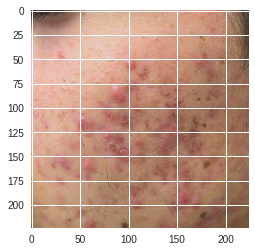

In [102]:
link = 'http://1.bp.blogspot.com/-kUK99T4MN2Y/VdNdLupc52I/AAAAAAAAABg/zU_obN8CfOQ/s1600/acne_0001_10731602084e470e78b7dfe-2.jpg'

def download(url):
  resp = requests.get(link)
  arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
  img = cv2.imdecode(arr, -1)
  return resize(img)

img = download(link)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

img = reshape(img)
print(f"image shape {img.shape}")

In [103]:
req = np.array(img[np.newaxis, ...])
model.predict(req)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)